In [538]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import mutual_info_classif,chi2
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import roc_auc_score, mean_squared_error

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import CondensedNearestNeighbour

import category_encoders as ce

plt.style.use('seaborn-colorblind')
%matplotlib inline

def dprint(df, inds):
    return df[df.index.isin(inds)]

# Методы инженеринга признаков

## 1. Анализ данных

### 1.1 Загрузка дататсета

In [443]:
data = pd.read_csv('data/adult.data')
data.columns = [
    'age','workclass','fnlwgt','education','education-num','marital-status',
    'occupation','relationship','race','sex','capital-gain','capital-loss',
    'hours-per-week','native-country','target'
]
print(data.shape)
data.head(8)

(32560, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
5,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
6,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
7,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K


### 1.2 Анализ признаков

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Data columns (total 15 columns):
age               32560 non-null int64
workclass         32560 non-null object
fnlwgt            32560 non-null int64
education         32560 non-null object
education-num     32560 non-null int64
marital-status    32560 non-null object
occupation        32560 non-null object
relationship      32560 non-null object
race              32560 non-null object
sex               32560 non-null object
capital-gain      32560 non-null int64
capital-loss      32560 non-null int64
hours-per-week    32560 non-null int64
native-country    32560 non-null object
target            32560 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


|Тип|Признаки|Количество|
|-|-|-|
|Числовой|age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week|6|
|Категриальный|workclass,education,marital-status,occupation,relationship,race,sex,native-country|8|
|Целевая переменная|target|1|



Посмотрим на уникальные значения признаков:

In [45]:
for col in data.columns:
    print('\r\n',col)
    print(data[col].unique())


 age
[50 38 53 28 37 49 52 31 42 30 23 32 40 34 25 43 54 35 59 56 19 39 20 45
 22 48 21 24 57 44 41 29 18 47 46 36 79 27 67 33 76 17 55 61 70 64 71 68
 66 51 58 26 60 90 75 65 77 62 63 80 72 74 69 73 81 78 88 82 83 84 85 86
 87]

 workclass
[' Self-emp-not-inc' ' Private' ' State-gov' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked']

 fnlwgt
[ 83311 215646 234721 ...  34066  84661 257302]

 education
[' Bachelors' ' HS-grad' ' 11th' ' Masters' ' 9th' ' Some-college'
 ' Assoc-acdm' ' Assoc-voc' ' 7th-8th' ' Doctorate' ' Prof-school'
 ' 5th-6th' ' 10th' ' 1st-4th' ' Preschool' ' 12th']

 education-num
[13  9  7 14  5 10 12 11  4 16 15  3  6  2  1  8]

 marital-status
[' Married-civ-spouse' ' Divorced' ' Married-spouse-absent'
 ' Never-married' ' Separated' ' Married-AF-spouse' ' Widowed']

 occupation
[' Exec-managerial' ' Handlers-cleaners' ' Prof-specialty'
 ' Other-service' ' Adm-clerical' ' Sales' ' Craft-repair'
 ' Transport-moving' ' Farming-fishin

Признаки `workclass` и `native-country` категориальные и имеют уникальное значение `?`. Это явный пропуск, заменим его в выборке на `NaN`.

In [46]:
data['workclass'] = data['workclass'].str.replace('?',str(np.NaN))
data['native-country'] = data['native-country'].str.replace('?',str(np.NaN))
data[data.index.isin([13,26])][['workclass','native-country']]

,workclass,native-country
13,Private,nan
26,nan,South


### 1.3 Пропущенные значения

Проверим пропуски стендартным функционалом pandas.

In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Data columns (total 15 columns):
age               32560 non-null int64
workclass         32560 non-null object
fnlwgt            32560 non-null int64
education         32560 non-null object
education-num     32560 non-null int64
marital-status    32560 non-null object
occupation        32560 non-null object
relationship      32560 non-null object
race              32560 non-null object
sex               32560 non-null object
capital-gain      32560 non-null int64
capital-loss      32560 non-null int64
hours-per-week    32560 non-null int64
native-country    32560 non-null object
target            32560 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


Ниже опишем функцию, которая считает пропуски и выводит их соотношение. Результат также сохраняет в файл.

In [57]:
def check_missing(data,output_path=None):    
    result = pd.concat([data.isnull().sum(),data.isnull().mean()],axis=1)
    result = result.rename(index=str,columns={0:'total missing',1:'proportion'})
    if output_path is not None:
        result.to_csv(output_path+'missing.csv')
        print(output_path, 'missing.csv')
    return result

check_missing(data=data)

,total missing,proportion
age,0,0.0
workclass,0,0.0
fnlwgt,0,0.0
education,0,0.0
education-num,0,0.0
marital-status,0,0.0
occupation,0,0.0
relationship,0,0.0
race,0,0.0
sex,0,0.0


Пропусков числовых признаках нет, функция не учитывает пропуски в категориальных.

Для проверки функции создадим пропуски синтетически на числовых признаках `hours-per-week` и `age`.

In [63]:
# Синтетически создаем пропуски

# С заданной частотой выбираем индексы, которые будем считать пропусками
hoursperweek_missing_indexes = data.sample(frac=0.1).index
age_missing_indexes = data.sample(frac=0.15).index

# Копируем признаки и заполняем их NaN
data_hoursperweek, data_age = data['hours-per-week'].copy(), data['age'].copy()
data_hoursperweek[hoursperweek_missing_indexes], data_age[age_missing_indexes] = np.NaN, np.NaN

# Копируем датасет и присваиваем ему признаки с пропущенными значениями
data_1 = data.copy()
data_1['hours-per-week'] = data_hoursperweek
data_1['age'] = data_age

# Проверяем работу нашей функции `check_missing()`
check_missing(data=data_1)

,total missing,proportion
age,4884,0.15
workclass,0,0.00
fnlwgt,0,0.00
education,0,0.00
education-num,0,0.00
marital-status,0,0.00
occupation,0,0.00
relationship,0,0.00
race,0,0.00
sex,0,0.00


Функция выдала ожидаемый результат, соотношение пропусков соотвествует заданным частотам `0.1` и `0.15`.

## 2. Пропуски

### 2.1 Удаление пропусков

Создадим функцию для удаления пропущенных значений

In [64]:
def drop_missing(data,axis=0):
    data_copy = data.copy(deep=True)
    data_copy = data_copy.dropna(axis=axis,inplace=False)
    return data_copy

In [65]:
print("Начальный размер данных: {}".format(data_1.shape))
data_2 = drop_missing(data=data_1)
print("Конечный размер данных: {}".format(data_2.shape))

Начальный размер данных: (32560, 15)
Конечный размер данных: (24920, 15)


### 2.2 Создание признаков для пропущенных значений

Создадим функциую, которая каждому принаку на входе создат новый признак с бинарной отметкой пропущенного значения

In [101]:
def add_var_denote_NA(data,NA_col=[]):
    from warnings import warn
    
    data_copy = data.copy(deep=True)
    for i in NA_col:
        if data_copy[i].isnull().sum()>0:
            data_copy[i+'_is_NA'] = np.where(data_copy[i].isnull(),1,0)
        else:
            warn("Нет пропущенных значений в признаке {}".format(i))         
    return data_copy

In [78]:
data_3 = add_var_denote_NA(data=data_1,NA_col=['age','hours-per-week'])
data_3[(data_3.age_is_NA == 1)|(data_3['hours-per-week_is_NA'] == 1)].head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target,age_is_NA,hours-per-week_is_NA
1,NaN,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40.0,United-States,<=50K,1,0
5,NaN,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16.0,Jamaica,<=50K,1,0
8,NaN,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40.0,United-States,>50K,1,0
10,NaN,State-gov,141297,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40.0,India,>50K,1,0
15,25.0,Self-emp-not-inc,176756,HS-grad,9,Never-married,Farming-fishing,Own-child,White,Male,0,0,NaN,United-States,<=50K,0,1


Новые признаки `age_is_NA` и `hours-per-week_is_NA` появились и содержат значения `1` для записей с пропусками у старых признаков `age` и `hours-per-week`.

### 2.3 Заполнение пропусков выборочным значением

Создадим функцию, которая для выборчных признаков создает их копию и заполняет пропуски заданным значением.

In [100]:
def impute_NA_with_arbitrary(data,impute_value,NA_col=[]):
    from warnings import warn
    
    data_copy = data.copy(deep=True)
    for i in NA_col:
        if data_copy[i].isnull().sum()>0:
            data_copy[i+'_'+str(impute_value)] = data_copy[i].fillna(impute_value)
        else:
            warn("Нет пропущенных значений в признаке {}".format(i))
    return data_copy

In [82]:
data_4 = impute_NA_with_arbitrary(data=data_1,impute_value=-999,NA_col=['age','hours-per-week'])
data_4[(data_4['age_-999'] == -999) | (data_4['hours-per-week_-999'] == -999)].head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target,age_-999,hours-per-week_-999
1,NaN,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40.0,United-States,<=50K,-999.0,40.0
5,NaN,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16.0,Jamaica,<=50K,-999.0,16.0
8,NaN,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40.0,United-States,>50K,-999.0,40.0
10,NaN,State-gov,141297,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40.0,India,>50K,-999.0,40.0
15,25.0,Self-emp-not-inc,176756,HS-grad,9,Never-married,Farming-fishing,Own-child,White,Male,0,0,NaN,United-States,<=50K,25.0,-999.0


Новые признаки `age_-999` и `hours-per-week_-999` появились и содержат значения -999 для записей с пропусками у старых признаков `age` и `hours-per-week`.

### 2.4 Заполнение пропущенных значений средним/медианой/модой

Создадим функцию, которая для выборчных признаков создает их копию на основании выбранной стратегии и заполняет пропуски в соотвествии со стратегией. 

Функция будет реализовывать три стратегии заполнения: 
- Средним значением
- Медианным значением
- Наиболее часто встречающимся (функция моды)

In [99]:
def impute_NA_with_avg(data,strategy='mean',NA_col=[]):
    from warnings import warn
    
    data_copy = data.copy(deep=True)
    for i in NA_col:
        if data_copy[i].isnull().sum()>0:
            if strategy=='mean':
                data_copy[i+'_impute_mean'] = data_copy[i].fillna(data[i].mean())
            elif strategy=='median':
                data_copy[i+'_impute_median'] = data_copy[i].fillna(data[i].median())
            elif strategy=='mode':
                data_copy[i+'_impute_mode'] = data_copy[i].fillna(data[i].mode()[0])
        else:
            warn("Нет пропущенных значений в признаке {}".format(i))
    return data_copy  

#### Заполнение средним значением

In [110]:
print("Среднее признака `age`: {}".format(
    round(data_1['age'].mean(),5)
))
print("Среднее признака `hours-per-week`: {}".format(
    round(data_1['hours-per-week'].mean(),5)
))

data_5 = impute_NA_with_avg(data=data_1,strategy='mean',NA_col=['age','hours-per-week'])
data_5[(data_5['age'].isin([np.NaN])) | (data_5['hours-per-week'].isin([np.NaN]))].head()

Среднее признака `age`: 38.54195
Среднее признака `hours-per-week`: 40.45383


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target,age_impute_mean,hours-per-week_impute_mean
1,NaN,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40.0,United-States,<=50K,38.54195,40.000000
5,NaN,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16.0,Jamaica,<=50K,38.54195,16.000000
8,NaN,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40.0,United-States,>50K,38.54195,40.000000
10,NaN,State-gov,141297,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40.0,India,>50K,38.54195,40.000000
15,25.0,Self-emp-not-inc,176756,HS-grad,9,Never-married,Farming-fishing,Own-child,White,Male,0,0,NaN,United-States,<=50K,25.00000,40.453829


Новые признаки `age_impute_mean` и `hours-per-week_impute_mean` появились и содержат значения `38.54195` и `40.453829` для записей с пропусками у старых признаков `age` и `hours-per-week`.

#### Заполнение медианным значением

In [111]:
print("Медиана признака `age`: {}".format(
    round(data_1['age'].median(),5)
))
print("Медиана признака `hours-per-week`: {}".format(
    round(data_1['hours-per-week'].median(),5)
))

data_6 = impute_NA_with_avg(data=data_1,strategy='median',NA_col=['age','hours-per-week'])
data_6[(data_6['age'].isin([np.NaN])) | (data_6['hours-per-week'].isin([np.NaN]))].head()

Медиана признака `age`: 37.0
Медиана признака `hours-per-week`: 40.0


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target,age_impute_median,hours-per-week_impute_median
1,NaN,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40.0,United-States,<=50K,37.0,40.0
5,NaN,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16.0,Jamaica,<=50K,37.0,16.0
8,NaN,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40.0,United-States,>50K,37.0,40.0
10,NaN,State-gov,141297,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40.0,India,>50K,37.0,40.0
15,25.0,Self-emp-not-inc,176756,HS-grad,9,Never-married,Farming-fishing,Own-child,White,Male,0,0,NaN,United-States,<=50K,25.0,40.0


Новые признаки `age_impute_median` и `hours-per-week_impute_median` появились и содержат значения `37.0` и `40.0` для записей с пропусками у старых признаков `age` и `hours-per-week`.

#### Заполнение значением по моде 

In [117]:
print("Мода признака `age`: {}".format(
    round(data_1['age'].mode()[0],5)
))
print("Мода признака `hours-per-week`: {}".format(
    round(data_1['hours-per-week'].mode()[0],5)
))

data_7 = impute_NA_with_avg(data=data_1,strategy='mode',NA_col=['age','hours-per-week'])
data_7[(data_7['age'].isin([np.NaN])) | (data_7['hours-per-week'].isin([np.NaN]))].head()

Мода признака `age`: 34.0
Мода признака `hours-per-week`: 40.0


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target,age_impute_mode,hours-per-week_impute_mode
1,NaN,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40.0,United-States,<=50K,34.0,40.0
5,NaN,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16.0,Jamaica,<=50K,34.0,16.0
8,NaN,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40.0,United-States,>50K,34.0,40.0
10,NaN,State-gov,141297,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40.0,India,>50K,34.0,40.0
15,25.0,Self-emp-not-inc,176756,HS-grad,9,Never-married,Farming-fishing,Own-child,White,Male,0,0,NaN,United-States,<=50K,25.0,40.0


Новые признаки `age_impute_mode` и `hours-per-week_impute_mode` появились и содержат значения `34.0` и `40.0` для записей с пропусками у старых признаков `age` и `hours-per-week`.

### 2.5 Заполнение пропусков значением из "хвоста" распределения

<img src="normal_distrib.jpg">

Создадим функцию, которая для выборчных признаков создает их копию и каждый пропуск заполняет значением из хвоста распределения. Значение должно быть больше $\mu+3\sigma$, чтобы диапазон вероятности заначения был 
$p$ = 100.00%-99.73% = 0.27%

<span style="color: red">[ ! ] Использование данной функции спорно, так как правило 3𝜎 справедливо для выборки с нормальным распределением!</span>

In [120]:
def impute_NA_with_end_of_distribution(data,NA_col=[]):
    from warnings import warn
    
    data_copy = data.copy(deep=True)
    for i in NA_col:
        if data_copy[i].isnull().sum()>0:
            data_copy[i+'_impute_end_of_distri'] = data_copy[i].fillna(data[i].mean()+3*data[i].std())
        else:
            warn("Нет пропущенных значений в признаке {}".format(i))
    return data_copy     

In [127]:
print("Значение признака `age`: {}".format(
    round(data_1['age'].mean()+3*data_1['age'].std(), 6)
))
print("Значение признака `hours-per-week`: {}".format(
    round(data_1['hours-per-week'].mean()+3*data_1['hours-per-week'].std(), 6)
))

data_8 = impute_NA_with_end_of_distribution(data=data_1,NA_col=['age','hours-per-week'])
data_8[(data_8['age'].isin([np.NaN])) | (data_8['hours-per-week'].isin([np.NaN]))].head()

Значение признака `age`: 79.438942
Значение признака `hours-per-week`: 77.649289


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target,age_impute_end_of_distri,hours-per-week_impute_end_of_distri
1,NaN,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40.0,United-States,<=50K,79.438942,40.000000
5,NaN,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16.0,Jamaica,<=50K,79.438942,16.000000
8,NaN,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40.0,United-States,>50K,79.438942,40.000000
10,NaN,State-gov,141297,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40.0,India,>50K,79.438942,40.000000
15,25.0,Self-emp-not-inc,176756,HS-grad,9,Never-married,Farming-fishing,Own-child,White,Male,0,0,NaN,United-States,<=50K,25.000000,77.649289


Новые признаки `age_impute_end_of_distri` и `hours-per-week_impute_end_of_distri` появились и содержат значения `79.438942` и `77.649289` для записей с пропусками у старых признаков `age` и `hours-per-week`.

### 2.6 Заполнение пропусков случайными значениями

Создадим функцию, которая для выборчных признаков создает их копию и каждый пропуск заполняет случайным значением из содержащихся в признаке.

In [126]:
def impute_NA_with_random(data,NA_col=[],random_state=0):
    from warnings import warn
    
    data_copy = data.copy(deep=True)
    for i in NA_col:
        if data_copy[i].isnull().sum()>0:
            data_copy[i+'_random'] = data_copy[i]
            random_sample = data_copy[i].dropna().sample(data_copy[i].isnull().sum(), random_state=random_state)
            random_sample.index = data_copy[data_copy[i].isnull()].index
            data_copy.loc[data_copy[i].isnull(), str(i)+'_random'] = random_sample
        else:
            warn("Нет пропущенных значений в признаке {}".format(i))
    return data_copy 

In [140]:
data_9 = impute_NA_with_random(data=data_1,NA_col=['age','hours-per-week'])

data_9[(data_9['age'].isin([np.NaN])) | (data_9['hours-per-week'].isin([np.NaN]))].head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target,age_random,hours-per-week_random
1,NaN,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40.0,United-States,<=50K,52.0,40.0
5,NaN,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16.0,Jamaica,<=50K,63.0,16.0
8,NaN,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40.0,United-States,>50K,38.0,40.0
10,NaN,State-gov,141297,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40.0,India,>50K,40.0,40.0
15,25.0,Self-emp-not-inc,176756,HS-grad,9,Never-married,Farming-fishing,Own-child,White,Male,0,0,NaN,United-States,<=50K,25.0,40.0


Новые признаки `age_random` и `hours-per-week_random` появились и содержат случайные значения из своего диапазона. Не очень удачный способ заоплнения пропусков!

## 3. Выбросы

### 3.1 Детекция выбросов с помощью выборочных значений

Выведем графики типа "ящик с усами" для признаков `age` и `hours-per-week`.

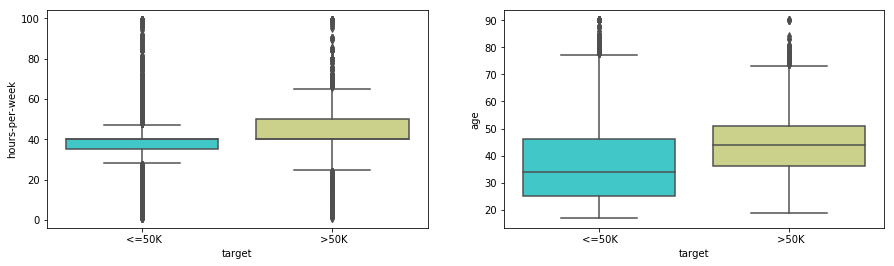

In [138]:
fig, axs = plt.subplots(ncols=2,figsize=(15,4))
sns.boxplot(x="target", y="hours-per-week", data=data, palette='rainbow',ax=axs[0]);
sns.boxplot(x="target", y="age", data=data, palette='rainbow',ax=axs[1]);

Из графика признаков визульано выберем границы выбросов. Для`age` возьмем границы `5 и 78`, а для `hours-per-week` границы `22 и 64`.

Создадим функцию, которая для датасета по верхней и нижней границе выбросов считает количество и долю.

In [142]:
def outlier_detect_arbitrary(data,col,upper_fence,lower_fence):
    para = (upper_fence, lower_fence)
    tmp = pd.concat([data[col]>upper_fence,data[col]<lower_fence],axis=1)
    outlier_index = tmp.any(axis=1)
    print('Количество выбросов в данных:',outlier_index.value_counts()[1])
    print('Доля выбросов:',outlier_index.value_counts()[1]/len(outlier_index))    
    return outlier_index, para

In [143]:
index,para = outlier_detect_arbitrary(data=data,col='age',upper_fence=78,lower_fence=5)
print('Верхняя граница:',para[0],'\nНижняя граница:',para[1])

Количество выбросов в данных: 143
Доля выбросов: 0.004391891891891892
Верхняя граница: 78 
Нижняя граница: 5


In [144]:
index,para = outlier_detect_arbitrary(data=data,col='hours-per-week',upper_fence=64,lower_fence=22)
print('Верхняя граница:',para[0],'\nНижняя граница:',para[1])

Количество выбросов в данных: 4018
Доля выбросов: 0.12340294840294841
Верхняя граница: 64 
Нижняя граница: 22


### 3.2 Интерквартильное расстояние (размах)

Интерквартильным расстоянием(размахом) или интерквартильным интервалом (InterQuartile range, IQR) называется разность между третьим и первым квартилями (Q3 - Q1). Интерквартильный размах является характеристикой разброса значений в выборке.

Создадим функцию, которая для датасета считает 25-й и 75-й квантили, интерквартильный размах и корректирует его границы по некторому заданному порогу.

In [228]:
def outlier_detect_IQR(data,col,threshold=3):    
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    Lower_fence = data[col].quantile(0.25) - (IQR * threshold)
    Upper_fence = data[col].quantile(0.75) + (IQR * threshold)
    para = (Upper_fence, Lower_fence)
    tmp = pd.concat([data[col]>Upper_fence,data[col]<Lower_fence],axis=1)
    outlier_index = 0
    outlier_index_counts = 0
    rejection_fraction = 0
    try:
        outlier_index = tmp.any(axis=1)
        outlier_index_counts = outlier_index.value_counts()[1]
        rejection_fraction = outlier_index_counts/len(outlier_index)
    except:
        outlier_index = 0
        outlier_index_counts = 0
        rejection_fraction = 0
        
    print('Количество выбросов в данных:',outlier_index_counts)
    print('Доля выбросов:',rejection_fraction)
    return outlier_index, para

In [236]:
index,para = outlier_detect_IQR(data=data_1,col='age',threshold=2)
print('Верхняя граница:',para[0],'\nНижняя граница:',para[1])

Количество выбросов в данных: 36
Доля выбросов: 0.0011056511056511057
Верхняя граница: 88.0 
Нижняя граница: -12.0


In [237]:
index,para = outlier_detect_IQR(data=data_1,col='hours-per-week',threshold=3)
print('Верхняя граница:',para[0],'\nНижняя граница:',para[1])

Количество выбросов в данных: 3963
Доля выбросов: 0.12171375921375921
Верхняя граница: 60.0 
Нижняя граница: 25.0


### 3.3 Среднее-среднеквадратичное отклонение

Создадим функцию, которая для датасета считает мат. ожидание(МО) и создает границы от МО на стандартное отклонение с учетом некоторого порога.

In [238]:
def outlier_detect_mean_std(data,col,threshold=3):
    Upper_fence = data[col].mean() + threshold * data[col].std()
    Lower_fence = data[col].mean() - threshold * data[col].std()   
    para = (Upper_fence, Lower_fence)   
    tmp = pd.concat([data[col]>Upper_fence,data[col]<Lower_fence],axis=1)
    outlier_index = tmp.any(axis=1)
    print('Количество выбросов в данных:',outlier_index.value_counts()[1])
    print('Доля выбросов:',outlier_index.value_counts()[1]/len(outlier_index))
    return outlier_index, para

In [256]:
index,para = outlier_detect_mean_std(data=data,col='age',threshold=3)
print('Верхняя граница:',para[0],'\nНижняя граница:',para[1])

Количество выбросов в данных: 121
Доля выбросов: 0.0037162162162162164
Верхняя граница: 79.50355938902604 
Нижняя граница: -2.3402915757582363


In [257]:
index,para = outlier_detect_mean_std(data=data,col='hours-per-week',threshold=3)
print('Верхняя граница:',para[0],'\nНижняя граница:',para[1])

Количество выбросов в данных: 440
Доля выбросов: 0.013513513513513514
Верхняя граница: 77.48032346291092 
Нижняя граница: 3.394615112027651


### 3.4 Медианное абсолютное отклонение (MAD) 

Медианное абсолютное отклонение используется вместо среднего отклонения, когда крайние значения из области отклонений должны оказывать меньшее влияние на величину отклонения. Используется оно в силу того, что медиана затрагивается крайними значениями области отклонений в меньшей степени, чем среднее.

Создадим функцию, для расчета $MAD$.

In [244]:
def outlier_detect_MAD(data,col,threshold=3.5):
    median = data[col].median()
    median_absolute_deviation = np.median([np.abs(y - median) for y in data[col]])
    modified_z_scores = pd.Series([0.6745 * (y - median) / median_absolute_deviation for y in data[col]])
    outlier_index = np.abs(modified_z_scores) > threshold
    print('Количество выбросов в данных:',outlier_index.value_counts()[1])
    print('Доля выбросов:',outlier_index.value_counts()[1]/len(outlier_index))
    return outlier_index

In [258]:
index = outlier_detect_MAD(data=data,col='age',threshold=3.5)

Количество выбросов в данных: 43
Доля выбросов: 0.0013206388206388206


In [259]:
index = outlier_detect_MAD(data=data,col='hours-per-week',threshold=3.5)

Количество выбросов в данных: 6001
Доля выбросов: 0.18430589680589682


### 3.5 Замена выброса выборочным значением

Создадим функцию для замены выбросов установленным значением по индексам выбросов из вышеописанных функций. 

In [260]:
def impute_outlier_with_arbitrary(data,outlier_index,value,col=[]):
    data_copy = data.copy(deep=True)
    for i in col:
        data_copy.loc[outlier_index,i] = value
    return data_copy

In [292]:
index_age = outlier_detect_MAD(data=data,col='age',threshold=3.5)
data_10 = impute_outlier_with_arbitrary(data=data,outlier_index=index_age,
                                         value=-999,col=['age'])
data_10[index_age].head()

Количество выбросов в данных: 43
Доля выбросов: 0.0013206388206388206


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
221,-999,Private,51744,HS-grad,9,Never-married,Other-service,Not-in-family,Black,Male,0,2206,40,United-States,<=50K
1039,-999,Private,137018,HS-grad,9,Never-married,Other-service,Not-in-family,White,Female,0,0,40,United-States,<=50K
1934,-999,Private,221832,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,<=50K
2302,-999,Private,52386,Some-college,10,Never-married,Other-service,Not-in-family,Asian-Pac-Islander,Male,0,0,35,United-States,<=50K
2890,-999,Private,171956,Some-college,10,Separated,Adm-clerical,Own-child,White,Female,0,0,40,Puerto-Rico,<=50K


### 3.6 Виндзоризация

Распределение многих статистических данных может сильно зависеть от выбросов. Типичная стратегия состоит в том, чтобы установить все выбросы на определенный процентиль данных; например, при 90% -ной винсоризации все данные ниже 5-го процентиля устанавливаются на 5-й процентиль, а данные выше 95-го процентиля устанавливаются на 95-й процентиль. Виндзоризованные оценки, как правило, более устойчивы к выбросам, чем их более стандартные формы, хотя есть альтернативы, такие как обрезка, которые достигнут аналогичного эффекта.

{92, 19, 101, 58, 1053, 91, 26, 78, 10, 13, −40, 101, 86, 85, 15, 89, 89, 28, −5, 41}  

{92, 19, 101, 58, 101, 91, 26, 78, 10, 13, −5, 101, 86, 85, 15, 89, 89, 28, −5, 41} 

In [293]:
def windsorization(data,col,para,strategy='both'):
    data_copy = data.copy(deep=True)  
    if strategy == 'both':
        data_copy.loc[data_copy[col]>para[0],col] = para[0]
        data_copy.loc[data_copy[col]<para[1],col] = para[1]
    elif strategy == 'top':
        data_copy.loc[data_copy[col]>para[0],col] = para[0]
    elif strategy == 'bottom':
        data_copy.loc[data_copy[col]<para[1],col] = para[1]  
    return data_copy

In [313]:
print('Начальные значения:')
print(data['age'].describe())

data_11 = windsorization(data=data,col='age',para=para,strategy='bottom')

print('\r\nЗначения после виндсоризации:')
print(data_11['age'].describe())

Начальные значения:
count    32560.000000
mean        38.581634
std         13.640642
min         17.000000
25%         28.000000
50%         37.000000
75%         48.000000
max         90.000000
Name: age, dtype: float64

Значения после виндсоризации:
count    32560.000000
mean        38.581634
std         13.640642
min         17.000000
25%         28.000000
50%         37.000000
75%         48.000000
max         90.000000
Name: age, dtype: float64


### 3.7 Удаление выбросов

In [315]:
def drop_outlier(data,outlier_index):
    data_copy = data[~outlier_index]
    return data_copy

In [320]:
index_age = outlier_detect_MAD(data=data,col='age',threshold=3.5)

print('\r\nЗначения до удаления выбросов:')
print('Макс.:',data['age'].max())
print('Мин.:',data['age'].min())

data_12 = drop_outlier(data=data,outlier_index=index_age)

print('\r\nЗначения после удаления выбросов:')
print('Макс.:',data_12['age'].max())
print('Мин.:',data_12['age'].min())

Количество выбросов в данных: 43
Доля выбросов: 0.0013206388206388206

Значения до удаления выбросов:
Макс.: 90
Мин.: 17

Значения после удаления выбросов:
Макс.: 88
Мин.: 17


### 3.8 Замена выбросов средним/медианой/модой

In [334]:
def impute_outlier_with_avg(data,col,outlier_index,strategy='mean'):
    data_copy = data.copy(deep=True)
    if strategy=='mean':
        data_copy.loc[outlier_index,col] = data_copy[col].mean()
    elif strategy=='median':
        data_copy.loc[outlier_index,col] = data_copy[col].median()
    elif strategy=='mode':
        data_copy.loc[outlier_index,col] = data_copy[col].mode()[0]           
    return data_copy

In [339]:
index_age = outlier_detect_MAD(data=data,col='age',threshold=3.5)

print('\r\nЧасть данных с выбросами по age:')
print(data[index_age]['age'].head())

print('\r\nЧасть данных с выбросами по age c заменой средним:')
data_13 = impute_outlier_with_avg(data=data,col='age',outlier_index=index_age,strategy='mean')
print(data_13[index_age]['age'].head())

print('\r\nЧасть данных с выбросами по age c заменой медианой:')
data_13 = impute_outlier_with_avg(data=data,col='age',outlier_index=index_age,strategy='median')
print(data_13[index_age]['age'].head())

print('\r\nЧасть данных с выбросами по age c заменой по моде:')
data_13 = impute_outlier_with_avg(data=data,col='age',outlier_index=index_age,strategy='mode')
print(data_13[index_age]['age'].head())

Количество выбросов в данных: 43
Доля выбросов: 0.0013206388206388206

Часть данных с выбросами по age:
221     90
1039    90
1934    90
2302    90
2890    90
Name: age, dtype: int64

Часть данных с выбросами по age c заменой средним:
221     38.581634
1039    38.581634
1934    38.581634
2302    38.581634
2890    38.581634
Name: age, dtype: float64

Часть данных с выбросами по age c заменой медианой:
221     37.0
1039    37.0
1934    37.0
2302    37.0
2890    37.0
Name: age, dtype: float64

Часть данных с выбросами по age c заменой по моде:
221     36
1039    36
1934    36
2302    36
2890    36
Name: age, dtype: int64


## 4. Шкалирование данных

Подготовим данные для примеров без категориальных признаков.

In [444]:
data_target = data['target'].map({' <=50K':0, ' >50K':1})
non_object_futures = data.select_dtypes(exclude=['object']).columns
data_14 = data[non_object_futures].copy(deep=True)
data_14['target'] = data_target
data_14.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,target
0,50,83311,13,0,0,13,0
1,38,215646,9,0,0,40,0
2,53,234721,7,0,0,40,0
3,28,338409,13,0,0,40,0
4,37,284582,14,0,0,40,0


Разделим выборку на тренировочную и тестовую.

In [445]:
X_train, X_test, y_train, y_test = train_test_split(data_14, data_14.target, test_size=0.2,
                                                    random_state=0)
X_train.shape, X_test.shape

((26048, 7), (6512, 7))

### 4.1 Нормализация данных

In [446]:
X_train.head(6)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,target
12467,34,117444,13,0,0,65,1
15282,54,109413,13,0,0,50,0
24869,35,198202,9,0,0,54,0
18822,33,190511,4,2176,0,35,0
26403,50,138270,9,0,0,40,0
7842,42,222596,9,0,0,40,1


In [447]:
X_train_copy = X_train.copy(deep=True)
columns = X_train_copy.drop(columns=['target'],axis=1).columns

ss = StandardScaler().fit(X_train[columns])
X_train_copy[columns] = ss.transform(X_train_copy[columns])

X_train_copy.head(6)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,target
12467,-0.336285,-0.693152,1.130492,-0.146565,-0.217349,1.995908,1
15282,1.132723,-0.769988,1.130492,-0.146565,-0.217349,0.774635,0
24869,-0.262834,0.079496,-0.420373,-0.146565,-0.217349,1.100308,0
18822,-0.409735,0.005912,-2.358954,0.144548,-0.217349,-0.446637,0
26403,0.838921,-0.493900,-0.420373,-0.146565,-0.217349,-0.039546,0
7842,0.251318,0.312884,-0.420373,-0.146565,-0.217349,-0.039546,1


### 4.2 Мин-Макс шкалирование

In [448]:
X_train.head(6)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,target
12467,34,117444,13,0,0,65,1
15282,54,109413,13,0,0,50,0
24869,35,198202,9,0,0,54,0
18822,33,190511,4,2176,0,35,0
26403,50,138270,9,0,0,40,0
7842,42,222596,9,0,0,40,1


In [449]:
X_train_copy = X_train.copy(deep=True)
columns = X_train_copy.drop(columns=['target'],axis=1).columns

mms = MinMaxScaler().fit(X_train[columns])
X_train_copy[columns] = mms.transform(X_train_copy[columns])

print(X_train_copy['age'].max())
print(X_train_copy['age'].min())

X_train_copy.head(6)

1.0
0.0


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,target
12467,0.232877,0.071913,0.800000,0.00000,0.0,0.653061,1
15282,0.506849,0.066343,0.800000,0.00000,0.0,0.500000,0
24869,0.246575,0.127930,0.533333,0.00000,0.0,0.540816,0
18822,0.219178,0.122596,0.200000,0.02176,0.0,0.346939,0
26403,0.452055,0.086359,0.533333,0.00000,0.0,0.397959,0
7842,0.342466,0.144851,0.533333,0.00000,0.0,0.397959,1


### 4.3 Робустное шкалирование

In [450]:
X_train.head(6)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,target
12467,34,117444,13,0,0,65,1
15282,54,109413,13,0,0,50,0
24869,35,198202,9,0,0,54,0
18822,33,190511,4,2176,0,35,0
26403,50,138270,9,0,0,40,0
7842,42,222596,9,0,0,40,1


In [451]:
X_train_copy = X_train.copy(deep=True)
columns = X_train_copy.drop(columns=['target'],axis=1).columns

rs = RobustScaler().fit(X_train[columns])
X_train_copy[columns] = rs.transform(X_train_copy[columns])

X_train_copy.head(6)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,target
12467,-0.15,-0.512874,1.000000,0.0,0.0,5.0,1
15282,0.85,-0.579844,1.000000,0.0,0.0,2.0,0
24869,-0.10,0.160557,-0.333333,0.0,0.0,2.8,0
18822,-0.20,0.096422,-2.000000,2176.0,0.0,-1.0,0
26403,0.65,-0.339209,-0.333333,0.0,0.0,0.0,0
7842,0.25,0.363975,-0.333333,0.0,0.0,0.0,1


## 5. Энкодинг переменных 

Подготовим категориальные признаки для кодирования.

In [452]:
data_target = data['target'].map({' <=50K':0, ' >50K':1})
object_futures = data.select_dtypes(include=['object']).columns
data_15 = data[object_futures].copy(deep=True)
data_15['target'] = data_target
data_15.head()

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,target
0,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,0
1,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,0
2,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,0
3,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,0
4,Private,Masters,Married-civ-spouse,Exec-managerial,Wife,White,Female,United-States,0


Подготовим тренеровочную выборку.

In [453]:
X_train, X_test, y_train, y_test = train_test_split(data_15, data_15.target, test_size=0.2,
                                                    random_state=0)
X_train.shape, X_test.shape

((26048, 9), (6512, 9))

### 5.1 One-Hot encoding

In [454]:
data_16 = pd.get_dummies(data_15,drop_first=True)
data_16.head()

,target,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_ 11th,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### 5.2 Энкодинг значением

In [455]:
ord_enc = ce.OrdinalEncoder(cols=['sex']).fit(X_train,y_train)

In [456]:
data_17 = ord_enc.transform(data_15)
data_17.head(6)

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,target
0,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,1,United-States,0
1,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,1,United-States,0
2,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,1,United-States,0
3,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,2,Cuba,0
4,Private,Masters,Married-civ-spouse,Exec-managerial,Wife,White,2,United-States,0
5,Private,9th,Married-spouse-absent,Other-service,Not-in-family,Black,2,Jamaica,0


### 5.3 Таргет энкодинг

In [457]:
target_enc = ce.TargetEncoder(cols=['sex']).fit(X_train,y_train)
data_18 = target_enc.transform(data_15)
data_18.head(6)

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,target
0,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,0.305057,United-States,0
1,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,0.305057,United-States,0
2,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,0.305057,United-States,0
3,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,0.111254,Cuba,0
4,Private,Masters,Married-civ-spouse,Exec-managerial,Wife,White,0.111254,United-States,0
5,Private,9th,Married-spouse-absent,Other-service,Not-in-family,Black,0.111254,Jamaica,0


### 5.4 WOE энкодинг

In [458]:
woe_enc = ce.WOEEncoder(cols=['sex']).fit(X_train,y_train)
data_19 = woe_enc.transform(data_15)
data_19.head(6)

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,target
0,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,0.321991,United-States,0
1,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,0.321991,United-States,0
2,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,0.321991,United-States,0
3,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,-0.931861,Cuba,0
4,Private,Masters,Married-civ-spouse,Exec-managerial,Wife,White,-0.931861,United-States,0
5,Private,9th,Married-spouse-absent,Other-service,Not-in-family,Black,-0.931861,Jamaica,0


## 6. Feature Selection

In [459]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
data = pd.DataFrame(np.c_[data['data'], data['target']],
                  columns= np.append(data['feature_names'], ['target']))
data.head(5)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0


In [460]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(labels=['target'], axis=1), 
                                                    data.target, test_size=0.2,
                                                    random_state=0)
X_train.shape, X_test.shape

((455, 30), (114, 30))

### 6.1 Константные значения

In [465]:
def constant_feature_detect(data,threshold=0.98):    
    data_copy = data.copy(deep=True)
    quasi_constant_feature = []
    for feature in data_copy.columns:
        predominant = (data_copy[feature].value_counts() / np.float(
                      len(data_copy))).sort_values(ascending=False).values[0]
        if predominant >= threshold:
            quasi_constant_feature.append(feature)
    print(len(quasi_constant_feature),'константные переменные.',quasi_constant_feature)    
    return quasi_constant_feature

In [462]:
quasi_constant_feature = constant_feature_detect(data=X_train,threshold=0.9)

0 константные переменные


In [463]:
X_train['dummy'] = np.floor(X_train['worst smoothness']*10)
X_train.dummy.value_counts() / np.float(len(X_train))

1.0    0.923077
0.0    0.068132
2.0    0.008791
Name: dummy, dtype: float64

In [467]:
quasi_constant_feature = constant_feature_detect(data=X_train,threshold=0.9)

1 константные переменные. ['dummy']


In [468]:
X_train.drop(labels=quasi_constant_feature,axis=1,inplace=True)
print(X_train.shape)

(455, 30)


### 6.2 Корреляционная фильтрация

In [469]:
def corr_feature_detect(data,threshold=0.8):
    
    corrmat = data.corr()
    corrmat = corrmat.abs().unstack() 
    corrmat = corrmat.sort_values(ascending=False)
    corrmat = corrmat[corrmat >= threshold]
    corrmat = corrmat[corrmat < 1] 
    corrmat = pd.DataFrame(corrmat).reset_index()
    corrmat.columns = ['feature1', 'feature2', 'corr']
   
    grouped_feature_ls = []
    correlated_groups = []
    
    for feature in corrmat.feature1.unique():
        if feature not in grouped_feature_ls:
    
            correlated_block = corrmat[corrmat.feature1 == feature]
            grouped_feature_ls = grouped_feature_ls + list(
                correlated_block.feature2.unique()) + [feature]
    
            correlated_groups.append(correlated_block)
    return correlated_groups

In [470]:
corr = corr_feature_detect(data=X_train,threshold=0.9)
for i in corr:
    print(i,'\n')

          feature1         feature2      corr
0   mean perimeter      mean radius  0.998185
6   mean perimeter        mean area  0.986692
14  mean perimeter  worst perimeter  0.970507
19  mean perimeter     worst radius  0.969520
33  mean perimeter       worst area  0.941920 

           feature1      feature2      corr
12  perimeter error  radius error  0.978323
30  perimeter error    area error  0.944995 

          feature1             feature2      corr
36  mean concavity  mean concave points  0.914627 

        feature1       feature2      corr
38  mean texture  worst texture  0.908182 

                feature1             feature2      corr
40  worst concave points  mean concave points  0.906312 



### 6.3 Взаимная информация

In [471]:
def mutual_info(X,y,select_k=10):

    if select_k >= 1:
        sel_ = SelectKBest(mutual_info_classif, k=select_k).fit(X,y)
        col = X.columns[sel_.get_support()]
        
    elif 0 < select_k < 1:
        sel_ = SelectPercentile(mutual_info_classif, percentile=select_k*100).fit(X,y)
        col = X.columns[sel_.get_support()]   
        
    else:
        raise ValueError("select_k должно быть положительным значением")
    
    return col

In [472]:
mi = mutual_info(X=X_train,y=y_train,select_k=3)
print(mi)

Index(['mean concave points', 'worst perimeter', 'worst area'], dtype='object')


In [473]:
mi = mutual_info(X=X_train,y=y_train,select_k=0.2)
print(mi)

Index(['mean perimeter', 'mean concave points', 'worst radius',
       'worst perimeter', 'worst area', 'worst concave points'],
      dtype='object')


### 6.4 Хи-квадрат тест

In [474]:
def chi_square_test(X,y,select_k=10):

    if select_k >= 1:
        sel_ = SelectKBest(chi2, k=select_k).fit(X,y)
        col = X.columns[sel_.get_support()]
    elif 0 < select_k < 1:
        sel_ = SelectPercentile(chi2, percentile=select_k*100).fit(X,y)
        col = X.columns[sel_.get_support()]   
    else:
        raise ValueError("select_k должно быть положительным значением")  
    
    return col

In [475]:
chi = chi_square_test(X=X_train,y=y_train,select_k=3)
print(chi)

Index(['mean area', 'area error', 'worst area'], dtype='object')


In [476]:
chi = chi_square_test(X=X_train,y=y_train,select_k=0.2)
print(chi)

Index(['mean perimeter', 'mean area', 'area error', 'worst radius',
       'worst perimeter', 'worst area'],
      dtype='object')


### 6.5 Одномерный ROC-AUC

In [477]:
def univariate_roc_auc(X_train,y_train,X_test,y_test,threshold):

    roc_values = []
    for feature in X_train.columns:
        clf = DecisionTreeClassifier()
        clf.fit(X_train[feature].to_frame(), y_train)
        y_scored = clf.predict_proba(X_test[feature].to_frame())
        roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))
    roc_values = pd.Series(roc_values)
    roc_values.index = X_train.columns
    print(roc_values.sort_values(ascending=False))
    print(len(roc_values[roc_values > threshold]), len(X_train.columns))
    keep_col = roc_values[roc_values > threshold]
    return keep_col

In [478]:
uni_roc_auc = univariate_roc_auc(X_train=X_train,y_train=y_train,
                                   X_test=X_test,y_test=y_test,threshold=0.8)
print(uni_roc_auc)

worst perimeter            0.917275
worst area                 0.895840
worst radius               0.893458
worst concave points       0.863131
mean concavity             0.856939
mean radius                0.849000
mean area                  0.839314
worst concavity            0.831375
mean perimeter             0.829628
mean concave points        0.826453
area error                 0.812321
worst compactness          0.742299
radius error               0.740235
mean compactness           0.734360
perimeter error            0.680534
worst texture              0.647666
worst fractal dimension    0.640997
concavity error            0.640203
worst symmetry             0.620991
concave points error       0.618133
compactness error          0.607336
mean symmetry              0.591775
mean texture               0.573357
texture error              0.568593
worst smoothness           0.565100
mean smoothness            0.557637
fractal dimension error    0.542077
smoothness error           0

### 6.6 MSE анализ

In [479]:
def univariate_mse(X_train,y_train,X_test,y_test,threshold):

    mse_values = []
    for feature in X_train.columns:
        clf = DecisionTreeRegressor()
        clf.fit(X_train[feature].to_frame(), y_train)
        y_scored = clf.predict(X_test[feature].to_frame())
        mse_values.append(mean_squared_error(y_test, y_scored))
    mse_values = pd.Series(mse_values)
    mse_values.index = X_train.columns
    print(mse_values.sort_values(ascending=False))
    print(len(mse_values[mse_values > threshold]), len(X_train.columns))
    keep_col = mse_values[mse_values > threshold]
    return keep_col   

In [480]:
uni_mse = univariate_mse(X_train=X_train,y_train=y_train,
                            X_test=X_test,y_test=y_test,threshold=0.4)
print(uni_mse)

mean fractal dimension     0.491228
symmetry error             0.480750
fractal dimension error    0.456140
smoothness error           0.449561
texture error              0.412281
worst smoothness           0.403265
mean smoothness            0.399123
mean texture               0.396930
mean symmetry              0.363060
compactness error          0.361842
concave points error       0.357456
worst fractal dimension    0.355263
worst symmetry             0.350877
worst texture              0.333333
concavity error            0.333333
perimeter error            0.300439
mean compactness           0.258772
worst compactness          0.254386
radius error               0.245614
area error                 0.179825
mean perimeter             0.166667
mean concave points        0.166667
worst concavity            0.162281
mean radius                0.146930
mean concavity             0.142544
mean area                  0.140351
worst concave points       0.123782
worst area                 0

## 7. Oversampling/undersampling 

Нередко возникают ситуации, когда в обучающем наборе данных доля примеров некоторого класса слишком мала (этот класс будем называть миноритарным, а другой, сильно представленный, — мажоритарным). Такие тенденции хорошо заметны в кредитном скоринге, в медицине, в директ-маркетинге. Построенный на таких наборах данных классификатор может оказаться абсолютно неэффективным.

Следует отметить то, что могут отличаться и издержки ошибочной классификации. Причем неверная классификация примеров миноритарного класса, как правило, обходится в разы дороже, чем ошибочная классификация примера мажоритарного класса.

Одним из подходов для решения указанной проблемы является применение различных стратегий сэмплинга, которые можно разделить на две группы: случайные и специальные.

In [529]:
def plot_classes(X,y,t):
    X_copy = X.copy(deep=True)
    X_copy['target'] = y
    class_1 = X_copy[X_copy.target == 1.0]
    class_0 = X_copy[X_copy.target == 0.0]
    
    fig = plt.figure()
    fig.suptitle(t, fontsize=10)
    plt.scatter(class_1['mean area'],class_1['mean texture'], c='red', marker='+')
    plt.scatter(class_0['mean area'],class_0['mean texture'], c= 'green', marker='^')
    del X_copy

### 7.1 SMOTE

Эта стратегия основана на идее генерации некоторого количества искусственных примеров, которые были бы «похожи» на имеющиеся в миноритарном классе, но при этом не дублировали их. Для создания новой записи находят разность $d=X_b–X_a$, где $X_a,X_b$ – векторы признаков «соседних» примеров $a$ и $b$ из миноритарного класса. Их находят, используя алгоритм ближайшего соседа (KNN). В данном случае необходимо и достаточно для примера $b$ получить набор из $k$ соседей, из которого в дальнейшем будет выбрана запись $b$. Остальные шаги алгоритма KNN не требуются.

Далее из $d$ путем умножения каждого его элемента на случайное число в интервале (0, 1) получают $\hat{d}$. Вектор признаков нового примера вычисляется путем сложения $X_a$ и $\hat{d}$. Алгоритм SMOTE позволяет задавать количество записей, которое необходимо искусственно сгенерировать. Степень сходства примеров $a$ и $b$ можно регулировать путем изменения значения k (числа ближайших соседей). 

Размер до сэмплинга: 455
Размер после сэмплинга: 580


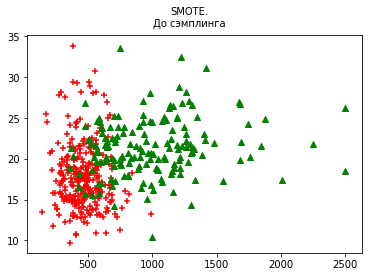

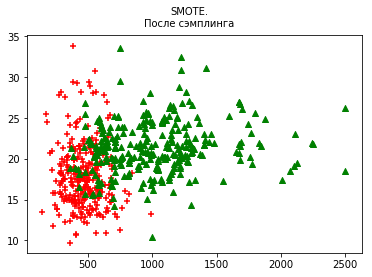

In [541]:
plot_classes(X_train, y_train,t='SMOTE.\nДо сэмплинга');
print('Размер до сэмплинга:',len(y_train))

sm = SMOTE(random_state=42)
x_res, y_res = sm.fit_resample(X_train, y_train)

X_res = pd.DataFrame(x_res, columns=X_train.columns)
plot_classes(X_res,y_res,t='SMOTE.\nПосле сэмплинга');
print('Размер после сэмплинга:',len(y_res))

### 7.2 Правило сосредоточенного ближайшего соседа (Condensed Nearest Neighbor Rule)

Пусть L – исходный набор данных. Из него выбираются все миноритарные примеры и (случайным образом) один мажоритарный. Обозначим это множество как S. Все примеры из L классифицируются по правилу одного ближайшего соседа (1-NN). Записи, получившие ошибочную метку, добавляются во множество S (рисунок 3).

Таким образом, мы будем учить классификатор находить отличие между похожими примерами, но принадлежащими к разным классам.

Размер до сэмплинга: 455
Размер после сэмплинга: 205


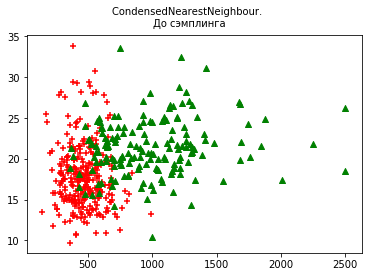

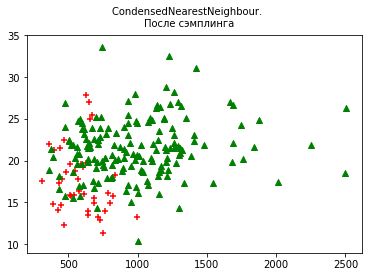

In [540]:
plot_classes(X_train, y_train,t='CondensedNearestNeighbour. \nДо сэмплинга');
print('Размер до сэмплинга:',len(y_train))

cn = CondensedNearestNeighbour(random_state=42)
x_res, y_res = cn.fit_resample(X_train, y_train)

X_res = pd.DataFrame(x_res, columns=X_train.columns)
plot_classes(X_res,y_res,t='CondensedNearestNeighbour. \nПосле сэмплинга');
print('Размер после сэмплинга:',len(y_res))